In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
df = pd.read_csv("D:Test//DL//CAC40.csv", parse_dates=['Date'])
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


`EDA`

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
# defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [5]:
# selecting any random company out of the name column
company_name = random.choice(df['Name'].unique().tolist())
# setting the start data and the end date
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2020,1,1)

# calling our function
specific_df = specific_data(company_name, start_date, end_date)

In [6]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
15667,BNP Paribas,2019-12-30,53.00,53.00,53.00,53.00,NaN
15668,BNP Paribas,2019-12-27,53.18,53.09,53.18,53.03,"4,945"
15669,BNP Paribas,2019-12-23,53.36,53.05,53.49,52.94,"3,443"
15670,BNP Paribas,2019-12-20,53.47,53.52,53.77,53.47,"1,943"
15671,BNP Paribas,2019-12-19,53.18,53.30,53.55,53.18,"8,39"


`VISUALIZATION`

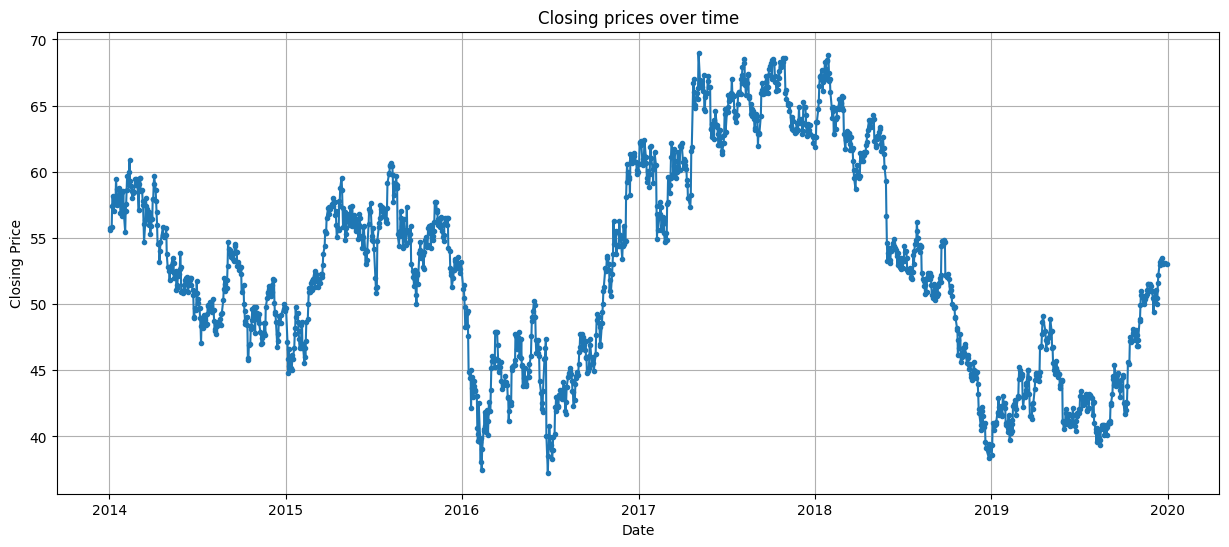

In [7]:
# line chart of closing prices over time
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

#plt.style.use("dark_background")
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Closing prices over time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

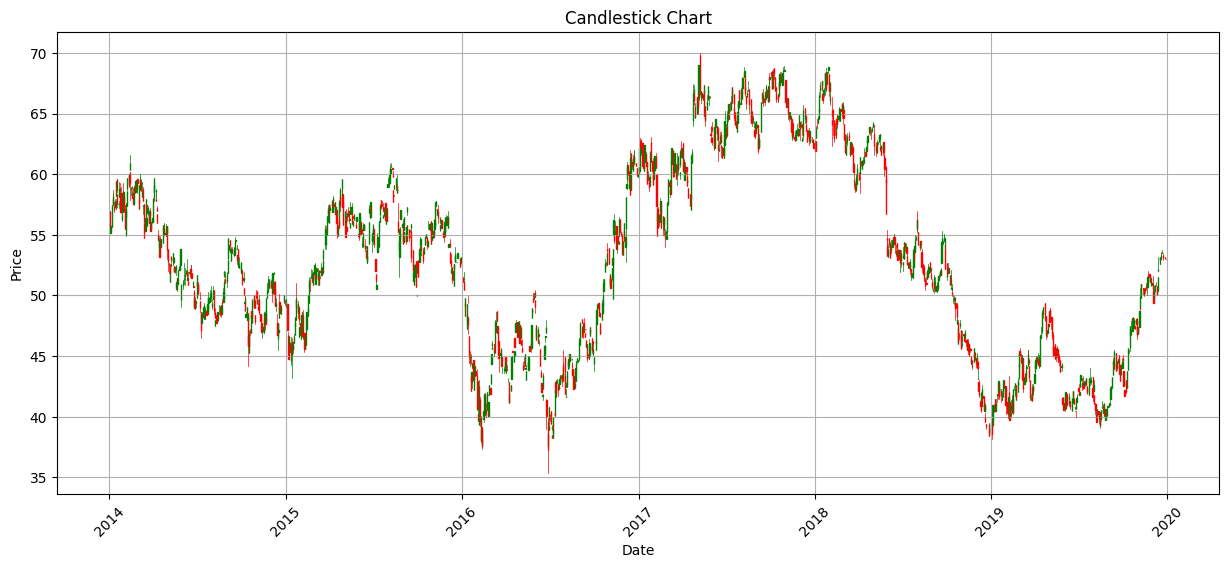

In [8]:
# Candlestick Chart

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

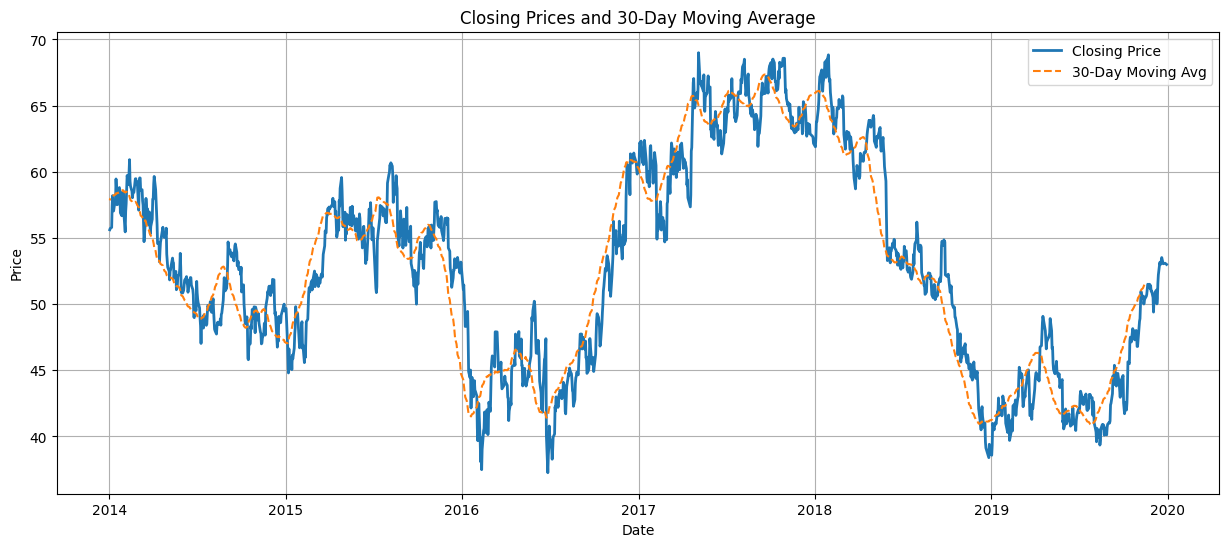

In [10]:
# closing prices and moving average
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

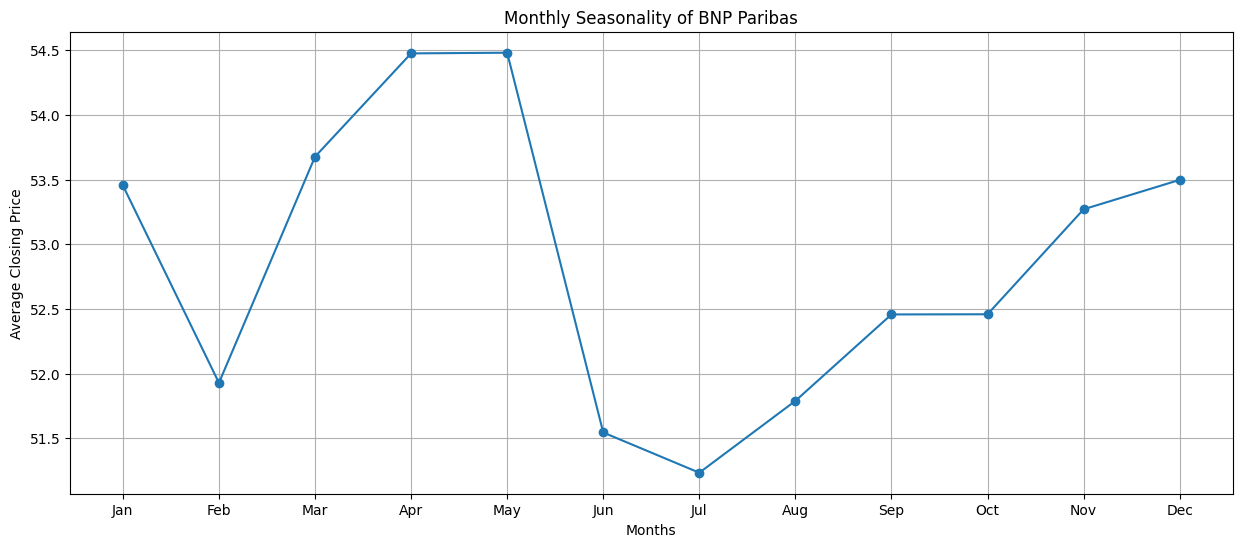

In [12]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [14]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Month
15667,BNP Paribas,2019-12-30,53.00,53.00,53.00,53.00,NaN,12
15668,BNP Paribas,2019-12-27,53.18,53.09,53.18,53.03,"4,945",12
15669,BNP Paribas,2019-12-23,53.36,53.05,53.49,52.94,"3,443",12
15670,BNP Paribas,2019-12-20,53.47,53.52,53.77,53.47,"1,943",12
15671,BNP Paribas,2019-12-19,53.18,53.30,53.55,53.18,"8,39",12


In [15]:
new_df = specific_df.reset_index()['Closing_Price']

In [17]:
# normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1, 1))

In [18]:
# split the dataset
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [19]:
# define the sequence length (number of past time steps)
n_past = 60

# prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [20]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1151, 60)
(1151,)


Testing set size:-
(243, 60)
(243,)


(None, None)

In [21]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

`MODEL TRAINING`

In [22]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 

In [26]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [27]:
# defininf our callbacks
#checkpoints = ModelCheckpoint(filepath=)

# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=20,
          batch_size=32,
          verbose=1,
          callbacks= [early_stopping])

Epoch 1/20

36/36 [==============================] - 12s 94ms/step - loss: 0.0055 - accuracy: 0.0017 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 2/20
36/36 [==============================] - 2s 61ms/step - loss: 0.0047 - accuracy: 0.0017 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 3/20
36/36 [==============================] - 2s 60ms/step - loss: 0.0051 - accuracy: 0.0017 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 4/20
36/36 [==============================] - 2s 58ms/step - loss: 0.0049 - accuracy: 0.0017 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 5/20
36/36 [==============================] - 2s 59ms/step - loss: 0.0049 - accuracy: 0.0017 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 6/20
36/36 [==============================] - 2s 60ms/step - loss: 0.0046 - accuracy: 0.0017 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 7/20
36/36 [==============================] - 2s 63ms/step - loss: 0.0041 - accuracy: 0.0017 - val_loss: 0.0018 - val_accu

In [28]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 27ms/step


In [29]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [30]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

53.71061456113367
52.73453393567988


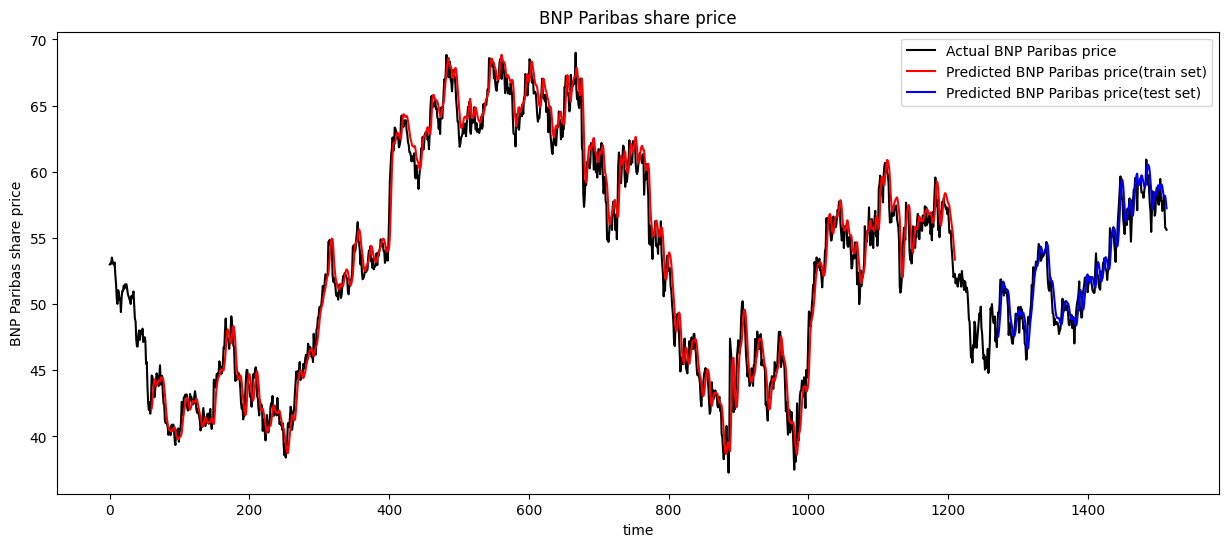

In [31]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()

In [32]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 46ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 57.24253463745117
Day 2: Predicted Price = 57.10462188720703
Day 3: Predicted Price = 57.253631591796875
Day 4: Predicted Price = 57.53135299682617
Day 5: Predicted Price = 57.84473419189453
Day 6: Predicted Price = 58.15378952026367
Day 7: Predicted Price = 58.445037841796875
Day 8: Predicted Price = 58.71550369262695
Day 9: Predicted Price = 58.96596908569336
Day 10: Predicted Price = 59.19874572753906


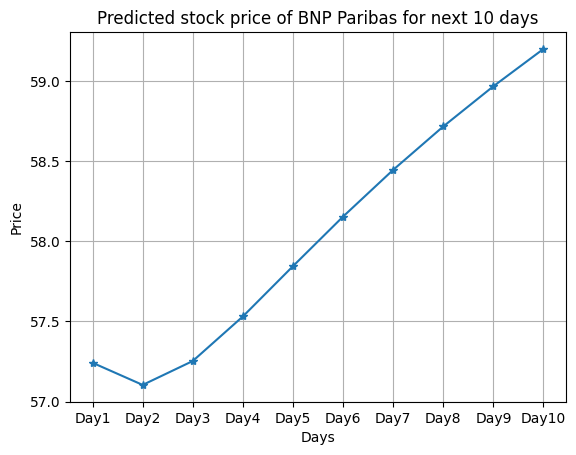

In [33]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()